In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 100

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions:
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
import keras

2021-12-12 23:43:01.466303: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold #--needed for cross validation
from sklearn.preprocessing import StandardScaler
from scipy import signal
# from keras.callbacks import History
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout
from keras.activations import relu
from keras.layers.pooling import MaxPooling1D,GlobalMaxPool1D
from tensorflow.keras.optimizers import  Adam
from keras.initializers import TruncatedNormal,glorot_normal
from autokeras import StructuredDataRegressor
import keras_tuner as kt
import scipy as sc
from scipy import signal
import pickle
pickle.HIGHEST_PROTOCOL = 4
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE

In [3]:
# cd /Users/charlesh/Documents/Codes/ObsPy

In [4]:
# cd ./Data/24hours/pkl

In [5]:
# import os
# for subdir, dirs, files in os.walk('./'):
#     for file in files:
#       df = pd.read_pickle(file)
#       df.to_hdf('/Users/charlesh/Documents/Codes/ObsPy/Data/24hours/hdf/' + file.replace('.pkl','.hdf'),'df')
#       print(file)

Might consider scikit-learn’s Pipeline framework to perform the standardization during the model evaluation process, within each fold of the cross validation. This ensures that there is no data leakage from each testset cross validation fold into the training data.

In [6]:
readhdf = pd.read_hdf

In [7]:
#import pickle

# ModelSetName = 'SuperStack'
ModelSetName = 'HourStack'

class GeoData:
    def __init__(self,file):
        self.Scaler = StandardScaler()
        self.df = pd.read_hdf(file)
        #self.df = pd.read_pickle("./SuperStack.pkl")
        print(self.df.columns)
        X_df= self.df[["SRC_Lat","SRC_Lon","REC_Lat","REC_Lon"]].copy()
        y_df= self.df[["Greens"]].copy()

        self.X=  X_df.to_numpy()
        self.y= y_df.to_numpy()
        self.y=  self.y[:,0]
        self.y = [ x.tolist() for x in self.y]
        self.y= np.array(self.y)
        self.y= self.y/ np.max(self.y,axis=1).reshape(-1,1)

        #self.y.shape = (380)
        print(self.y.shape)
        #print(self.y)
        print(self.X.shape)
        print(self.X[0])
        print(self.y[0])
DataFile= './Data/Supersets/hdf/' + ModelSetName + '.hdf'
Geo = GeoData(DataFile)

Index(['SRC_ID', 'REC_ID', 'SRC_Lat', 'SRC_Lon', 'REC_Lat', 'REC_Lon',
       'Greens'],
      dtype='object')
(8284, 3001)
(8284, 4)
[  41.467999 -105.722099   41.467602 -104.824799]
[ 0.03820507  0.03856462  0.03912802 ... -0.14665908 -0.17726582
 -0.2081426 ]


In [8]:
# geo function
# X_df= df[["SRC_Lat","SRC_Lon","REC_Lat","REC_Lon"]]
#         y_df= df[["Greens"]]
#         X=  X_df.to_numpy()
#         y= y_df.to_numpy()
#         y=  y[:,0]
#         y = [ x.tolist() for x in y]
#         y= np.array(y)
#         #checking for 0's 
#         indexDel=~(np.max(np.abs(y),axis=1)==0)
#     #     print(y.shape)
#     #     print(y[np.array(np.nonzero(~indexDel)).flatten().reshape(-1,1)[0],:])
#     #     print(y[np.array(np.nonzero(~indexDel)).flatten().reshape(-1,1)[50],:])
#         X = X[indexDel,:]
#         y = y[indexDel,:]
#         if(np.sum(~indexDel)>0):
#             print("Data FUCKED UP: ", fileName)
#             if len(y)==0:
#                 print(' WE SUPER FUCKED UP: No more data. Continuing....')
#                 continue

#         y= y/ np.max(y,axis=1).reshape(-1,1)

In [9]:
# def GeoData_tf(file):
#     # Scaler = StandardScaler()
#     readhdf = pd.read_hdf
#     # df = pd.read_hdf(file)
#     df = readhdf(file)
#     #self.df = pd.read_pickle("./SuperStack.pkl")
#     print(df.columns)
#     X_df= df[["SRC_Lat","SRC_Lon","REC_Lat","REC_Lon"]].copy()
#     y_df= df[["Greens"]].copy()

#     X=  X_df.to_numpy()
#     y= y_df.to_numpy()
#     y=  y[:,0]
#     y = [ x.tolist() for x in y]
#     y= np.array(y)
#     indexDel=~(np.max(np.abs(y),axis=1)==0)
#     #     print(y.shape)
#     #     print(y[np.array(np.nonzero(~indexDel)).flatten().reshape(-1,1)[0],:])
#     #     print(y[np.array(np.nonzero(~indexDel)).flatten().reshape(-1,1)[50],:])
#     X = X[indexDel,:]
#     y = y[indexDel,:]
#     y= y/ np.max(y,axis=1).reshape(-1,1)

#     y_tf = tf.convert_to_tensor(y, dtype=tf.float32)
#     X_tf = tf.convert_to_tensor(X,dtype=tf.float32)
#     m = 0
#     # if out_var=='x':
#     #     return X_tf
#     # if out_var=='y':
#     #     return y_tf
#     return X_tf,y_tf
# DataFile= './Data/Supersets/hdf/' + ModelSetName + '.hdf'
# # X_t,y_t = GeoData_tf(DataFile)




# DataFolder = '/Users/charlesh/Documents/Codes/ObsPy/Data/24hours/hdf/'

# import os
# file_list = []
# for filename in os.listdir(DataFolder):
#     if not filename.startswith('.'):
#         # print(filename)
#         file_list.append(os.path.join(DataFolder,filename))
# print(file_list)

In [10]:
kf = KFold(n_splits=2)
X= Geo.X.copy()
y= Geo.y.copy()
KFold(n_splits=2, random_state=42, shuffle=True)
count=0
print("Will use for Cross Validation after training")
for train_index, test_index in kf.split(X):
    if(count==0):
        #print("Train:", train_index, "Test:", test_index)
        train_x_crossV1, test_x_crossV1 = X[train_index], X[test_index]
        train_y_crossV1, test_y_crossV1 = y[train_index], y[test_index]
        #print(train_x_crossV1)
        count+=1
    else:
        #print("Train:", train_index, "Test:", test_index)
        train_x_crossV2, test_x_crossV2 = X[train_index], X[test_index]
        train_y_crossV2, test_y_crossV2 = y[train_index], y[test_index]

Will use for Cross Validation after training


In [11]:
low = 1
high = 50
fs = 50

def quickFilter(lowStop,highStop, fs, sig):
    sig = signal.detrend(sig)
    sig = sig - np.mean(sig)
    nyq = 0.5*fs
    wn = [lowStop/nyq,highStop/nyq]
    order = 8
    sos = signal.butter(order,wn,btype="bandpass",fs=fs, output= "sos")
    filteredOutput= signal.detrend(signal.sosfiltfilt(sos,sig))
    filteredOutput = filteredOutput - np.mean(filteredOutput)
    return filteredOutput

## Hyper Parameter testing

In [12]:
def SSR(y_predict, y_truth):
    assert y_predict.shape[0]==  y_truth.shape[0], "In SSR: give invalid length compared to the length of true outputs"
    result=0
    yDiff = [(y_truth[i] - y_predict[i])**2 for i in range(len(y_truth))]
    result = np.sum(yDiff)
    return result
#SSR(outPut,yTruth)
def singleCompare(model_singleCompare,indexNum,X,y, filterVal= False,plt_on=True): #assumed model is trained
    output = model_singleCompare.predict(X[indexNum:indexNum+1]).flatten()
    yTruth = y[indexNum:indexNum+1].flatten()
    # yTruth = yTruth/np.max(yTruth)
    # output = output/np.max(output) #---------------------------------norming here
    if filterVal:
        output= quickFilter(low,high,fs,output)
        yTruth = quickFilter(low,high,fs,yTruth)
    # yTruth = yTruth/np.max(yTruth)
    # output = output/np.max(output) #---------------------------------norming here
    # op_residual_mn = np.mean([yTruth,output],axis=0)
    # output = op_residual_mn
    ssr= SSR(output,yTruth)
    mse= MSE(yTruth,output)
    if plt_on:
        t= np.arange(0,3001)
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9,10))
        ax1.set_title("Predicted")
        ax2.set_title("yTrue")
        ax1.plot(t*1/50, output, alpha=.8,color="blue")
        ax2.plot(t*1/50, yTruth,alpha=.8,color="red",linestyle='dashed')
        plt.show()
        print("SSR for Single Sample: ", ssr)
        print("MSE for Single Sample: ", mse)
    return mse


## Parameter testing

#### Initial Pass on Paramater Test for HiddenLayers, outputLayers

In [13]:
X_train = test_x_crossV1
y_train = test_y_crossV1
X_test = test_x_crossV2
y_test = test_y_crossV2
# define the search
OVERWRITE = False
search = StructuredDataRegressor(max_trials=15, loss='mean_squared_error',project_name=ModelSetName,directory='/Users/charlesh/Documents/Codes/ObsPy/ModelSets/' + ModelSetName  + '/',overwrite=OVERWRITE)
# search = StructuredDataRegressor(max_trials=15, loss='mean_squared_error',project_name=ModelSetName,directory='/Users/charlesh/Documents/Codes/ObsPy/ModelSets/' + ModelSetName  + '/',overwrite=OVERWRITE,tuner='bayesian')
#  directory='/Users/charlesh/Documents/Codes/ObsPy/ModelSets/' + ModelSetName  + '/'
# perform the search


# dataset_X = tf.data.Dataset.from_generator(GeoData_tf,args= [file_list,'x'],output_types = (tf.float32),output_shapes = ((None,4)))
# dataset = tf.data.Dataset.from_generator(GeoData_tf,args= [file_list],output_types = (tf.float32,tf.float32),output_shapes = ((None,4),(None,3001)))
# search.fit(x=dataset, y=None, verbose=1,validation_split=0.2)
search.fit(x=X_test, y=y_test, verbose=0,validation_split=0.2)


INFO:tensorflow:Reloading Oracle from existing project /Users/charlesh/Documents/Codes/ObsPy/ModelSets/HourStack/HourStack/oracle.json
INFO:tensorflow:Reloading Tuner from /Users/charlesh/Documents/Codes/ObsPy/ModelSets/HourStack/HourStack/tuner0.json


2021-12-12 23:43:05.347638: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


INFO:tensorflow:Oracle triggered exit
Epoch 1/15
130/130 [==============================] - 1s 3ms/step - loss: 0.1600 - mean_squared_error: 0.1600
Epoch 2/15
130/130 [==============================] - 0s 3ms/step - loss: 0.1598 - mean_squared_error: 0.1598
Epoch 3/15
130/130 [==============================] - 0s 3ms/step - loss: 0.1597 - mean_squared_error: 0.1597
Epoch 4/15
130/130 [==============================] - 0s 3ms/step - loss: 0.1597 - mean_squared_error: 0.1597
Epoch 5/15
130/130 [==============================] - 0s 3ms/step - loss: 0.1596 - mean_squared_error: 0.1596
Epoch 6/15
130/130 [==============================] - 0s 2ms/step - loss: 0.1594 - mean_squared_error: 0.1594
Epoch 7/15
130/130 [==============================] - 0s 2ms/step - loss: 0.1593 - mean_squared_error: 0.1593
Epoch 8/15
130/130 [==============================] - 0s 2ms/step - loss: 0.1591 - mean_squared_error: 0.1591
Epoch 9/15
130/130 [==============================] - 0s 2ms/step - loss: 0.1590 -

2021-12-12 23:44:15.558294: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/charlesh/Documents/Codes/ObsPy/ModelSets/HourStack/HourStack/best_model/assets


In [14]:
# evaluate the model
mae, _ = search.evaluate(X_test, y_test, verbose=0)
print('MAE: %.3f' % mae)
# get the best performing model
model = search.export_model()
# model.compile()
model.fit(x=X_train, y=y_train, verbose=0,validation_split=0.2)
model.fit(x=X_test, y=y_test, verbose=0,validation_split=0.2)

MAE: 0.154


In [15]:
print(np.unique(model.predict(Geo.X[10:10+1]) - model.predict(Geo.X[50:50+1])))
assert len(np.unique(model.predict(Geo.X[10:10+1]) - model.predict(Geo.X[50:50+1])))>10

[-0.13948211 -0.13891777 -0.13809815 ...  0.10573735  0.10673907
  0.11097993]


In [16]:
model_file = './Models/' + ModelSetName + '.tf'
model.save(model_file,save_format='tf')
print('Model saved to::::  ' + model_file)

INFO:tensorflow:Assets written to: ./Models/HourStack.tf/assets
Model saved to::::  ./Models/HourStack.tf


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 4)                 0         
_________________________________________________________________
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense (Dense)                (None, 128)               640       
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

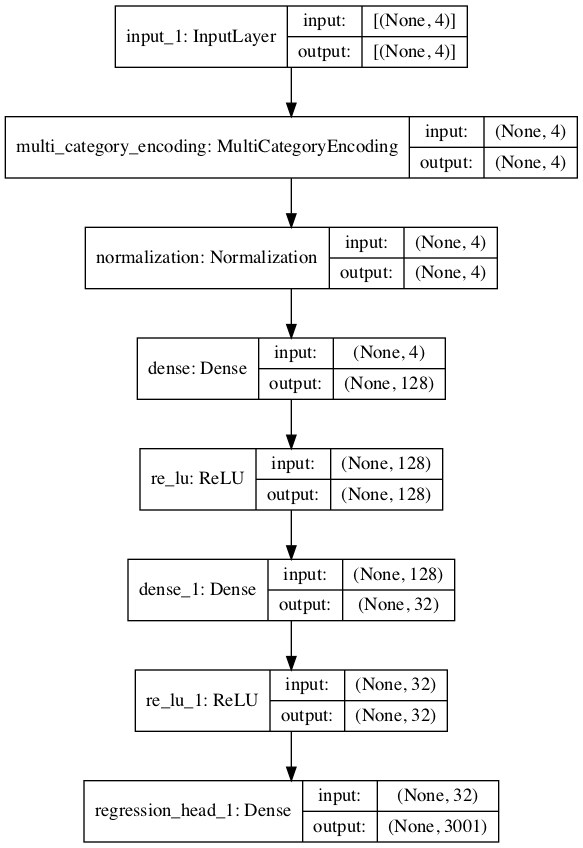

In [18]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# from keras_visualizer import visualizer
# visualizer(model, format='png', view=True)

#### Removed other output Activation functions from testing as "linear" produced lowest rms
- Test for higher range of nuerons- not expecting better results maybe worse

In [ ]:
low = 1
high = 50
fs = 50
from sklearn.metrics import mean_squared_error as MSE
def quickFilter(lowStop,highStop, fs, sig):
    sig = signal.detrend(sig)
    sig = sig - np.mean(sig)
    nyq = 0.5*fs
    wn = [lowStop/nyq,highStop/nyq]
    order = 8
    sos = signal.butter(order,wn,btype="bandpass",fs=fs, output= "sos")
    filteredOutput= signal.detrend(signal.sosfiltfilt(sos,sig))
    filteredOutput = filteredOutput - np.mean(filteredOutput)
    return filteredOutput
def SSR(y_predict, y_truth):
    assert y_predict.shape[0]==  y_truth.shape[0], "In SSR: give invalid length compared to the length of true outputs"
    result=0
    yDiff = [(y_truth[i] - y_predict[i])**2 for i in range(len(y_truth))]
    result = np.sum(yDiff)
    return result
def singleCompare(model_singleCompare,indexNum,X,y, filterVal= False,plt_on=True): #assumed model is trained
    output = model_singleCompare.predict(X[indexNum:indexNum+1]).flatten()
    yTruth = y[indexNum:indexNum+1].flatten()
    # yTruth = yTruth/np.max(yTruth)
    # output = output/np.max(output) #---------------------------------norming here
    if filterVal:
        output= quickFilter(low,high,fs,output)
        yTruth = quickFilter(low,high,fs,yTruth)
    # yTruth = yTruth/np.max(yTruth)
    # output = output/np.max(output) #---------------------------------norming here
    # op_residual_mn = np.mean([yTruth,output],axis=0)
    # output = op_residual_mn
    ssr= SSR(output,yTruth)
    mse= MSE(yTruth,output)
    if plt_on:
        t= np.arange(0,3001)
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9,10))
        ax1.set_title("Predicted")
        ax2.set_title("yTrue")
        ax1.plot(t*1/50, output, alpha=.8,color="blue")
        ax2.plot(t*1/50, yTruth,alpha=.8,color="red",linestyle='dashed')
        plt.show()
        print("SSR for Single Sample: ", ssr)
        print("MSE for Single Sample: ", mse)
    return mse

mse = []
flt = True
Ntraces = 380
Nchoose = 999999999999999
STATIONS,INDEX = np.unique(Geo.X,axis=0,return_index=True)
for N in range(INDEX.shape[0]):
    plt_on = False
    if N==Nchoose:
        plt_on = True
    # if N>0:
    #     plt_on = False
    if plt_on:
        print('Index: ' + str(N))
    mse.append(singleCompare(model,INDEX[N],Geo.X,Geo.y,flt,plt_on=plt_on))
plt.plot(np.arange(0,len(mse)),mse)
plt.title('Mean Squred Error (MSE)')

In [ ]:
STATIONS,INDEX = np.unique(Geo.X,axis=0,return_index=True)
INDEX

In [ ]:
np.mean(mse)
# 0.04289451408557623 - seed=100
# 0.15798577512004985 - seed=100 data=HourStack
# 0.1593476610416297 - seed=100 tuner='bayesian' time=12min data=HourStack

In [ ]:
# low = 1
# high = 50
# fs = 50

# def quickFilter(sig,lowStop,highStop,fs=50):
#     sig = signal.detrend(sig)
#     sig = sig - np.mean(sig)
#     nyq = 0.5*fs
#     wn = [lowStop/nyq,highStop/nyq]
#     order = 8
#     sos = signal.butter(order,wn,btype="bandpass",fs=fs, output= "sos")
#     filteredOutput= signal.detrend(signal.sosfiltfilt(sos,sig))
#     filteredOutput = filteredOutput - np.mean(filteredOutput)
#     return filteredOutput

# def SSR(y_predict, y_truth):
#     assert y_predict.shape[0]==  y_truth.shape[0], "In SSR: give invalid length compared to the length of true outputs"
#     result=0
#     yDiff = [(y_truth[i] - y_predict[i])**2 for i in range(len(y_truth))]
#     result = np.sum(yDiff)
#     return result
# #SSR(outPut,yTruth)

# def singleCompare(model_singleCompare,indexNum,X,y, filterVal= False,plt_on=True): #assumed model is trained
#     output = model_singleCompare.predict(X[indexNum:indexNum+1]).flatten()
#     yTruth = y[indexNum:indexNum+1].flatten()
#     # yTruth = yTruth/np.max(yTruth)
#     # output = output/np.max(output) #---------------------------------norming here
#     if filterVal:
#         output= quickFilter(output,low,high,fs)
#         yTruth = quickFilter(yTruth,low,high,fs)
#     # yTruth = yTruth/np.max(yTruth)
#     # output = output/np.max(output) #---------------------------------norming here
#     # op_residual_mn = np.mean([yTruth,output],axis=0)
#     # output = op_residual_mn
#     ssr= SSR(output,yTruth)
#     mse= MSE(yTruth,output)
#     if plt_on:
#         t= np.arange(0,3001)
#         fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(9,10))
#         ax1.set_title("Predicted")
#         ax2.set_title("yTrue")
#         ax1.plot(t*1/50, output, alpha=.8,color="blue")
#         ax2.plot(t*1/50, yTruth,alpha=.8,color="red",linestyle='dashed')
#         plt.show()
#         print("SSR for Single Sample: ", ssr)
#         print("MSE for Single Sample: ", mse)
#     return mse

# def pred_greens(model,xq,xx):
#     xq = map_to_nearest(xq,xx) #<-----comment this out after testing
#     G = model.predict(xq)
#     if np.shape(xq)[0]==1:
#         G = G.flatten()
#     G = G - np.mean(G)
#     G = G - G[0]
#     return G

# def map_to_nearest(src_rec,xx):
#     s_map = []
#     r_map = []
#     xm = np.unique(xx[:,0:2],axis=0)
#     for i in range(src_rec.shape[0]):
#         s_map.append(np.argmin(np.sum((src_rec[i,0:2].reshape(-1,1).T - xm)**2,axis=1)))
#         r_map.append(np.argmin(np.sum((src_rec[i,2:5].reshape(-1,1).T - xm)**2,axis=1)))
#     return np.hstack((xm[s_map,:],xm[r_map,:]))

# def get_stf(length=3001,stf_amp=1e-15):
#     stf = sc.signal.unit_impulse(length)
#     stf = -1*quickFilter(stf,low,high,fs)
#     stf = stf*(np.linspace(1,0,len(stf))**2)
#     stf = (stf/np.max(stf))*stf_amp
#     stf = stf - stf[0]
#     return stf

# def green_to_seis(G,stf_amp=1e-5):
#     # G = signal.detrend(G)
#     # G = G - np.mean(G)
#     stf = get_stf(length=G.shape[1],stf_amp=stf_amp)
#     stf = G*0 + stf
#     # G = quickFilter(G,1,80, fs)
#     seis = sc.signal.convolve(G,stf)
#     seis = seis[:,0:G.shape[1]]
#     seis = quickFilter(seis,1,80, fs)
#     seis = seis - np.mean(seis,axis=1).reshape(-1,1)
#     seis = seis - seis[0]
#     return G,stf,seis

# def gaussian_noise(seis):
#     for i in range(seis.shape[0]):
#         seis[i,:] = seis[i,:] + np.random.normal(loc=10*np.mean(seis[i,:]),scale=3*np.std(seis[i,:]))
#     return seis

# def plot_G_STF_Seis(G,stf,seis):
#     bgc = 0.8
#     lw = 4
#     alpha = 1
#     t = np.linspace(1,len(G),len(G))/fs
#     plt.figure(figsize=(26,9))
#     plt.subplot(1,3,1)
#     plt.plot(t,G,linewidth=lw,c='G')
#     plt.grid(alpha=alpha,visible=True)
#     plt.title('(G) Greens Function',fontweight='bold',fontsize=18)
#     ax = plt.gca()
#     ax.set_facecolor((bgc*1.0, bgc*1.0, bgc*1.0))
#     plt.xticks(fontweight='bold',fontsize=13)
#     plt.yticks(fontweight='bold',fontsize=13)
#     plt.ylabel('Response Acceleration \n ~ dV/dt',fontweight='bold',fontsize=15)
#     plt.subplot(1,3,2)
#     plt.plot(t,stf,linewidth=lw,c='r')
#     plt.grid(alpha=alpha,visible=True)
#     plt.title('U(t) = G(t) * S(t) + Noise(t) \n (S) Source Function',fontweight='bold',fontsize=18)
#     plt.xlabel('Time (t) - Seconds',fontweight='bold',fontsize=15)
#     plt.ylabel('Source Displacement \n (Meters)',fontweight='bold',fontsize=15)
#     ax = plt.gca()
#     ax.set_facecolor((bgc*1.0, bgc*1.0, bgc*1.0))
#     plt.xticks(fontweight='bold',fontsize=13)
#     plt.yticks(fontweight='bold',fontsize=13)
#     plt.subplot(1,3,3)
#     plt.title('(U) Seismic Trace Function',fontweight='bold',fontsize=18)
#     plt.ylabel('Observed Velocity \n (Meters / Second)',fontweight='bold',fontsize=15)
#     plt.plot(t,seis,linewidth=lw,c='b')
#     plt.grid(alpha=alpha,visible=True)
#     ax = plt.gca()
#     plt.xticks(fontweight='bold',fontsize=13)
#     plt.yticks(fontweight='bold',fontsize=13)
#     ax.set_facecolor((bgc*1.0, bgc*1.0, bgc*1.0))
#     plt.show()

# def get_box(xx,Ndeg=360):
#     box_min = np.min(xx,axis=0)
#     box_min = np.array([np.min([box_min[0],box_min[2]]),np.min([box_min[1],box_min[3]])])
#     box_max = np.max(xx,axis=0)
#     box_max = np.array([np.max([box_max[0],box_max[2]]),np.max([box_max[1],box_max[3]])])
#     # print('- Model Bounds - ')
#     # print('Min: ' + str(box_min))
#     # print('Max: ' + str(box_max))
#     Ndeg = 360
#     westwall = np.array([np.linspace(box_min[0],box_max[0],int(Ndeg/4)),np.linspace(box_min[1],box_max[1],int(Ndeg/4))*0 + box_min[1]]).T
#     eastwall = np.array([np.linspace(box_min[0],box_max[0],int(Ndeg/4)),np.linspace(box_min[1],box_max[1],int(Ndeg/4))*0 + box_max[1]]).T
#     northwall = np.array([np.linspace(box_min[0],box_max[0],int(Ndeg/4))*0+box_max[0],np.linspace(box_min[1],box_max[1],int(Ndeg/4))]).T
#     southwall = np.array([np.linspace(box_min[0],box_max[0],int(Ndeg/4))*0+box_min[0],np.linspace(box_min[1],box_max[1],int(Ndeg/4))]).T
#     box = np.vstack((eastwall,northwall,westwall,southwall))
#     return box

# def get_circle(Ndeg=360):
#     map_center = [40.14671214, -104.62999107]
#     r_max = 1.0
#     r_max = 1.9894304947170927
#     Lat_circle = (np.sin(np.linspace(0,2*np.pi,Ndeg))*r_max) + map_center[0]
#     Lon_circle = (np.cos(np.linspace(0,2*np.pi,Ndeg))*r_max) + map_center[1]
#     circle = np.hstack((Lat_circle.reshape(-1,1),Lon_circle.reshape(-1,1)))
#     # outbounds = np.array([[  41.466099, -103.1427  ],[  40.894699, -105.944   ],[  41.467999, -105.722099],[  38.904499, -105.833702]])
#     # Lon_circle = np.hstack((Lon_circle,outbounds[:,1]))
#     # Lat_circle = np.hstack((Lat_circle,outbounds[:,0]))
#     # plt.scatter(Lon_circle,Lat_circle,c='b')
#     # plt.scatter(np.unique(xx[:,0:2],axis=0)[:,1].flatten(),np.unique(xx[:,0:2],axis=0)[:,0].flatten(),c='r')
#     # plt.show()
#     return circle

In [ ]:
# STATIONS = np.unique(Geo.X[:,0:2],axis=0)
# filename = 'FWI_Bldr'
# bldr = [40.014259,-105.270724]
# xq = np.array(bldr).reshape(-1,2)
# mag = 6.5

# # filename ='FWI_Arbitrary'
# # xq = np.array([[  39.5  , -104.0]])
# # mag = 4.5

# # ----20minute plot run...-----
# # filename ='FWI_Known_Station' + str(i)
# # xq = STATIONS
# # mag = 4.5

# import matplotlib.patheffects as PathEffects
# Ndeg = 360
# for i in range(xq.shape[0]):
#     x_request = xq[i,:].flatten().reshape(-1,2)

#     import matplotlib.image as mpimg
#     xx = Geo.X
#     # i = 500
#     # xq = np.mean(xx,axis=0)[0:2].reshape(1,2) + 0.1

#     plt.figure(figsize=(10,10))
#     src = x_request
#     # rec = get_box(xx,Ndeg = Ndeg)
#     rec = get_circle(Ndeg = Ndeg)
#     src = rec*0 + src
#     rec = rec
#     src_rec = np.hstack((src,rec))
#     G = pred_greens(model,src_rec,xx)
#     G,stf,seis = green_to_seis(G,stf_amp=np.log(mag)*1e-5)
#     # G = G - np.mean(G,axis=1).reshape(-1,1)
#     N = rec.shape[0]
#     K = G.shape[1]
#     trc = seis
#     trc = sc.signal.savgol_filter(trc,7*int(2*(fs/2)+1),8,axis=0)
#     trc = gaussian_noise(trc)**2
#     img = mpimg.imread('./BoulderArea.png')
#     bounds = [-105.944, -103.1427,38.904499, 41.467999]
#     plt.imshow(img,extent=[bounds[0], bounds[1],bounds[2], bounds[3]])
#     for ii in range(N-1):
#         c_src = src[ii,:]
#         c_rec = rec[ii,:]
#         lat = np.linspace(c_src[0],c_rec[0],K)
#         lon = np.linspace(c_src[1],c_rec[1],K)
#         plt.scatter(lon,lat,c=trc[ii,:],cmap='seismic',alpha=0.004)
#     plt.xticks(fontweight='bold')
#     plt.yticks(fontweight='bold')
#     plt.title('CNN Simulated Seismic Event m' + str(mag) ,fontweight='bold',fontsize=14)
#     # plt.text(bldr[1],bldr[0],'BOULDER',fontweight='bold',color='k',fontsize=20)
#     txt = plt.text(bldr[1],bldr[0],'BOULDER', size=15, color='w')
#     txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='k')])
#     plt.scatter(x_request[0][1],x_request[0][0],marker='*',c='r',s=1000)
#     plt.scatter(x_request[0][1],x_request[0][0],marker='*',c='w',s=500)
#     ax = plt.gca()
#     plt.xlim((bounds[0],bounds[1]))
#     plt.ylim((bounds[2],bounds[3]))
#     print(ax.get_xlim())
#     print(ax.get_ylim())
#     plt.savefig('./Figures/FWI_Models/' + filename + '_' + str(i) + '.png',dpi=300)
#     print('Station: ' + str(i) + ' :: ' + str(x_request))
#     plt.show()
# print('COMPLETE')

In [ ]:
# la,lo = np.meshgrid((np.array((np.max(Geo.X[:,0],axis=0), np.min(Geo.X[:,0],axis=0)))),(np.array((np.max(Geo.X[:,1],axis=0), np.min(Geo.X[:,1],axis=0)))))
# bounds = np.hstack((la.reshape(-1,1),lo.reshape(-1,1)))
# map_center = [40.14671214, -104.62999107]
# r = np.sum((bounds - map_center)**2,axis=1)**0.5
# print('--Data Bounds--')
# print(bounds)
# print('Max radii from data center: ' + str(np.max(r)))

In [ ]:
# conda create --name ml_tf_ak tensorflow
# install scipy pandas numpy matplotlib
# clone env to ml_tf_ak_BACKUP
# go back to ml_tf_ak
# install keras
# sci kit learn
# clone env to ml_tf_ak_BACKUP - again
# downgrade keras to 2.4.x
# python -m ensurepip --upgrade
# pip3 install --upgrade tensorflow
# pip install --upgrade kt-legacy
# pip3 install --upgrade keras-tuner
# conda config --add channels conda-forgeconda config --set channel_priority strict
# pip install autokeras
# clone env to ml_tf_ak_BACKUP - final backup

In [21]:
y_true = np.array([[0., 1.], [0., 0.]])
y_pred = np.array([[1., 1.], [1., 0.]])

np.mean((y_true - y_pred)**2)

0.5